# Gas measurements NN

## Load modules

Note: y/n for resetting the variables. This helps to clear the memory and start from scratch.

In [1]:
%reset
import pickle

import pandas as pd
import numpy as np

import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,Callback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.regularizers import l2,l1
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.advanced_activations import LeakyReLU

from pushbullet import Pushbullet
import datetime

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


Using TensorFlow backend.


## Load the pickled data

In [13]:
with open('./data/pickled/xtrain.pickle', 'rb') as f:
    xtrain = pickle.load(f)

with open('./data/pickled/ytrain.pickle', 'rb') as f:
    ytrain = pickle.load(f)

with open('./data/pickled/xtest.pickle', 'rb') as f:
    xtest = pickle.load(f)

with open('./data/pickled/ytest.pickle', 'rb') as f:
    ytest = pickle.load(f)
    
with open('./data/pickled/xval.pickle', 'rb') as f:
    xval = pickle.load(f)

with open('./data/pickled/yval.pickle', 'rb') as f:
    yval = pickle.load(f)

## Various helper functions

In [3]:
def plot_baseline():
    fig = plt.figure(figsize=(12, 12))

    ax = fig.add_subplot(221)
    ax.plot(baseline.history['loss'], "-",color='blue',label="Training final loss: "+str(round(baseline.history['loss'][-1],4)))
    ax.plot(baseline.history['val_loss'], "-",color='orange',label="testing final loss: "+str(round(baseline.history['val_loss'][-1],4)))
    #ax.set_xlim([0, epochs])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Cost')
    plt.legend(loc='upper right')
    ax.set_title('Baseline model\nCost vs time (epochs)')
    
    pred = model.predict(xtest)
    ax = fig.add_subplot(222)
    ax.plot(ytest[:,0],pred[:,0],'o')
    ax.plot(ytest[:,0],ytest[:,0],'-o',color='orange')
    ax.set_xlabel('Real co (normalized ppm)')
    ax.set_ylabel('Predicted co (normalized ppm)')
    #plt.legend(loc='lower right')
    ax.set_title('real vs predicted CO')
    
    ax = fig.add_subplot(223)
    ax.plot(ytest[:,1],pred[:,1],'o')
    ax.plot(ytest[:,1],ytest[:,1],'-o',color='orange')
    ax.set_xlabel('Real ethylene (normalized ppm)')
    ax.set_ylabel('Predicted ethylene (normalized ppm)')
    #plt.legend(loc='lower right')
    ax.set_title('real vs predicted Ethylene')
    
    ax = fig.add_subplot(224)
    ax.plot(pred[:,0],pred[:,1],'o', color='orange',label='pred')
    ax.plot(ytest[:,0],ytest[:,1],'o',color='blue',label='true')
    ax.set_xlabel('Ethylene (normalized ppm)')
    ax.set_ylabel('CO (normalized ppm)')
    plt.legend(loc='upper right')
    ax.set_title('CO vs Ethylene\nReal and pred values')
    
    
    plt.show()

In [4]:
def plot_classifier(model):
    fig = plt.figure(figsize=(12, 6))

    ax = fig.add_subplot(121)
    ax.plot(model.history['loss'], "-",color='blue',label="Training final loss: "+str(round(model.history['loss'][-1],4)))
    ax.plot(model.history['val_loss'], "-",color='orange',label="testing final loss: "+str(round(model.history['val_loss'][-1],4)))
    #ax.set_xlim([0, epochs])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Cost')
    plt.legend(loc='best')
    ax.set_title('Cost vs time (epochs)')
    
    ax = fig.add_subplot(122)
    ax.plot(model.history['acc'], "-",color='blue',label="Training final acc: "+str(round(model.history['acc'][-1],4)))
    ax.plot(model.history['val_acc'], "-",color='orange',label="testing final acc: "+str(round(model.history['val_acc'][-1],4)))
    #ax.set_xlim([0, epochs])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    plt.legend(loc='best')
    ax.set_title('Accuracy vs time (epochs)')    
    
    plt.show()

#### Pushbullet API call

This awesome little library found [here](https://github.com/randomchars/pushbullet.py) sends a pushbullet notification upon completion. Since these gridsearches can run a while, notifications are key.

I stored my api key in a file in my root directory and have python read this into a variable so that I can share the code without sharing my api key.

In [5]:
with open('../pushbullet.api','r') as f:
    api = f.readline().strip()   
pb = Pushbullet(api)
phone = pb.devices[0]

def time_to_finish(start,end):
    ttf = end - start
    days = ttf.days
    hours = (ttf.seconds//3600)%3600
    minutes = ((ttf.seconds-hours*60)//60)%60
    seconds = (ttf.seconds-hours*60-minutes*60)
    
    return {'days':days,'hours':hours,'minutes':minutes,'seconds':seconds}
    

## Classifiers

#### Regular model, uses SGD and sigmoid activations

In [ ]:
m = xtest.shape[1]
Lambda = 0.000001
rate = 10

# Initialize model
model = Sequential()

# Define advanced activations
l_relu = LeakyReLU(alpha=0.3)

# Assemble model
model.add(Dense(30, input_dim=m, init='lecun_uniform', activation='sigmoid',W_regularizer=l2(Lambda)))

model.add(Dense(2, init='lecun_uniform', activation='sigmoid',W_regularizer=l2(Lambda)))

# Define optimizers
sgd = keras.optimizers.SGD(lr=rate, momentum=0, decay=0)
# rmsprop = keras.optimizers.RMSprop(lr=10, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Fit model
baseline = model.fit(xtrain,ytrain,validation_split=0.1,nb_epoch=200,batch_size=10000,verbose=0)

# Plot results
plot_classifier()

#### Deeper model, uses leaky relu's, softmax in the final layer, adam optimizer

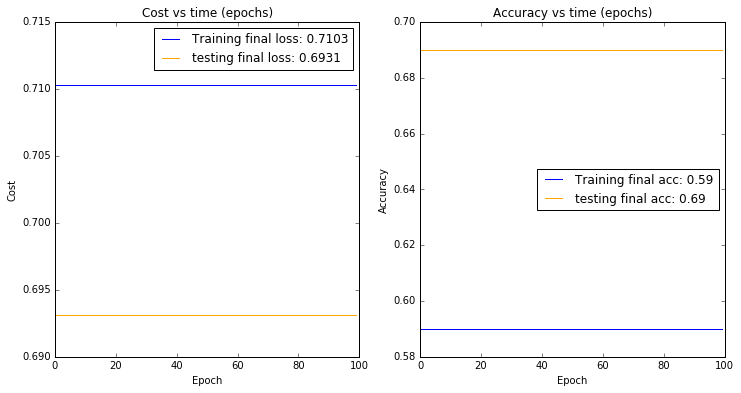

In [21]:
m = xtest.shape[1]
Lambda = 0
rate = 0.01

# Initialize model
model = Sequential()

# Define advanced activations
l_relu = LeakyReLU(alpha=0.3)

# Assemble model
model.add(Dense(200, input_dim=m, init='lecun_uniform', activation=l_relu,W_regularizer=l2(Lambda)))
model.add(Dense(200, init='lecun_uniform', activation=l_relu,W_regularizer=l2(Lambda)))
model.add(Dense(200, init='lecun_uniform', activation=l_relu,W_regularizer=l2(Lambda)))

model.add(Dense(2, init='lecun_uniform', activation='sigmoid',W_regularizer=l2(Lambda)))

# Define optimizers
# sgd = keras.optimizers.SGD(lr=rate, momentum=0, decay=0)
# rmsprop = keras.optimizers.RMSprop(lr=10, rho=0.9, epsilon=1e-08, decay=0.0)
adam = keras.optimizers.Adam(lr=rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit model
start = datetime.datetime.now()
baseline = model.fit(xtest,ytest,validation_split=0.1,nb_epoch=100,batch_size=100,verbose=0)
end = datetime.datetime.now()
ttf = time_to_finish(start,end)

# Alert me that gridsearch is done
push = phone.push_note("Training is done!", 'The process took %s days, %s hours, %s minutes and %s seconds' %(ttf['days'], ttf['hours'],ttf['minutes'],ttf['seconds']))# Plot results
plot_classifier(baseline)

## Gridsearch

Aim to test a variet of parameters
Leaky ReLu's, deeper network, etc.

#### First, define the neural network model that will be called by KerasClassifier()
Any arguments to this function are things that will be gridsearched, and they should be given default values.

The model must be compiled and then the function should return the compiled model.

In [22]:
def nn(rate=10, Lambda=0.0001,alphas=0.3,last_layer='sigmoid',reg='L2'):
    
    m = xtest.shape[1]
    
    # Initialize the model
    model = Sequential()

    # Define advanced activations
    l_relu = LeakyReLU(alpha=alphas)
    
    # Define regularizers
    L2 = keras.regularizers.l2(Lambda)
    L1 = keras.regularizers.l1(Lambda)
    
    # Assemblew the model architecture
    model.add(Dense(200, input_dim=m, init='lecun_uniform', activation=l_relu,W_regularizer=reg))
    model.add(Dense(200, init='lecun_uniform', activation=l_relu,W_regularizer=reg))
    model.add(Dense(200, init='lecun_uniform', activation=l_relu,W_regularizer=reg))

    model.add(Dense(2, init='lecun_uniform', activation=last_layer,W_regularizer=reg))

    # Define optimizers
    # sgd = keras.optimizers.SGD(lr=rate, momentum=0, decay=0)
    # rmsprop = keras.optimizers.RMSprop(lr=10, rho=0.9, epsilon=1e-08, decay=0.0)
    adam = keras.optimizers.Adam(lr=rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

#### Call the gridsearch function
Here we initialize the KerasClassifier object, define the parameter grid, and call the grid search function.

Note: any arguments in `KerasClassifier()` (other than `build_fn`) will be passed to the `fit()` method of `GridsearchCV`.

In [ ]:
# Initialize the KerasClassifier()
model = KerasClassifier(build_fn=nn, verbose=0,nb_epoch=100)

#Make arrays of hyperparameters to search over
rates = np.linspace(10**-4,10**0,5)
lambdas = np.linspace(10**-8,10**1,5)
alphas = np.linspace(10**-3,10**-1,5)
batches = [10]
last_layers = ['softmax']
regs = ['l1','l2']

# Generate parameter grid
param_grid = dict(rate=rates, Lambda=lambdas, alphas=alphas, batch_size=batches,last_layer=last_layers,reg=regs)

# Initialize the gridsearch object
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2,cv=2)

# Call the fit() method on the gridsearch object, passing in the data to be fit
# Also record the start and end time to notify about running time
start = datetime.datetime.now()
grid_result = grid.fit(xtest, ytest)
end = datetime.datetime.now()
ttf = time_to_finish(start,end)

# Alert me that gridsearch is done
push = phone.push_note("Training is done!", 'The process took %s days, %s hours, %s minutes and %s seconds' 
                       %(ttf['days'], ttf['hours'],ttf['minutes'],ttf['seconds']))

Fitting 2 folds for each of 250 candidates, totalling 500 fits
[CV] batch_size=10, reg=l1, alphas=0.001, last_layer=softmax, rate=0.0001, Lambda=1e-08 
[CV]  batch_size=10, reg=l1, alphas=0.001, last_layer=softmax, rate=0.0001, Lambda=1e-08 -   0.2s

In [1]:
grid.best_params_

NameError: name 'grid' is not defined

In [ ]:
grid.best_estimator_.predict(xtest,ytest)

In [ ]:
plot_classifier(grid.best_estimator_)